In [188]:
%matplotlib inline
import texttoideas as TI
import pandas as pd
import numpy as np
from pprint import pprint
from texttoideas.TermDocMatrix import TermDocMatrix, build_from_category_spacy_doc_iter
from texttoideas.RudderChart import *
import mpld3
mpld3.enable_notebook()

In [186]:
speeches = list(TI.iter_party_convention_speech(convention_speech_iter = TI.convention_speech_iter()))

category democrat
# speeches 123
category republican
# speeches 66


In [187]:
pprint([[cat, str(text)[:100].strip()] for cat, text in speeches[:3]])
pprint([[cat, str(text)[:100].strip()] for cat, text in speeches[-3:]])

[[u'democrat',
  'Thank you. Thank you. Thank you. Thank you so much.Thank you.Thank you so much. Thank you. Thank you'],
 [u'democrat',
  'Thank you so much. Tonight, I am so thrilled and so honored and so proud to introduce the love of my'],
 [u'democrat',
  'Thank you. It is a singular honor to be here tonight. Eight years ago in Boston, I introduced you to']]
[[u'republican',
  'To Chairman Priebus and to my fellow Americans who have traveled from every corner of this great cou'],
 [u'republican',
  'Absolutely. Thank you, Mr.Chairman.\nWelcome, everyone, to my home state of Florida, and we are so h'],
 [u'republican',
  "I am thrilled to add Utah's voice in support for Mitt Romney. Let me tell you about the America I kn"]]


In [189]:
term_doc_mat = build_from_category_spacy_doc_iter(speeches)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188


In [191]:
kessler_df = (term_doc_mat
      .get_kessler_scores_vs_background(scaler_algo='normcdf')
      .sort_values(by='kessler', ascending = False))
rudder_df = (term_doc_mat
      .get_rudder_scores_vs_background()
      .sort_values(by='rudder', ascending = True))
postratio_df = (term_doc_mat
      .get_posterior_mean_ratio_scores_vs_background()
      .sort_values(by='Log Posterior Mean Ratio', ascending = False))


In [22]:
fisher_df = term_doc_mat.get_fisher_scores_vs_background()

In [34]:
top_20_fisher = (fisher_df
                 .sort_values(by=['Bonferroni-corrected p-values', 'Odds ratio'], 
                              ascending = [True, False]).index[:20])

## Different methods for comparing 2012 convention speeches to background unigram counts

In [118]:
comparison_to_background_corpora = pd.DataFrame({
        'Top Kessler Terms (Freq)':list(kessler_df.iloc[:20].apply(lambda x: x.name + ' (%s)' % (int(x['corpus'])), axis=1)),
        'Top Rudder Terms (Freq)':list(rudder_df.iloc[:20].apply(lambda x: x.name + ' (%s)' % (int(x['corpus'])), axis=1)),
        'Top Fisher Terms (Freq)':list(fisher_df.iloc[:20].apply(lambda x: x.name + ' (%s)' % (int(x['corpus'])), axis=1))
    })
comparison_to_background_corpora


,Top Fisher Terms (Freq),Top Kessler Terms (Freq),Top Rudder Terms (Freq)
0,thank (366),obama (702),obamacare (33)
1,you (1627),romney (570),romneys (8)
2,so (553),mitt (501),yohana (3)
3,much (159),barack (248),nevadan (2)
4,very (137),republican (228),solyndra (2)
5,everybody (30),bless (132),breth (2)
6,michelle (20),president (1049),outeducate (2)
7,i (1948),democrat (127),vouchercare (2)
8,love (135),elect (102),bendiga (2)
9,a (2942),biden (46),gjelsvik (2)


In [139]:
df = term_doc_mat.get_term_freq_df()
df['kessler dem'] = np.array(term_doc_mat.get_kessler_scores('democrat', scaler_algo='percentile'))
df['kessler rep'] = np.array(term_doc_mat.get_kessler_scores('republican', scaler_algo='percentile'))
df['rudder dem'] = term_doc_mat.get_rudder_scores('democrat')
df['rudder rep'] = term_doc_mat.get_rudder_scores('republican')
df['logreg dem'], acc, bl = term_doc_mat.get_logistic_regression_coefs('democrat')
df['logreg rep'], acc, bl = term_doc_mat.get_logistic_regression_coefs('republican')


In [143]:
print 'Democratic Associations'
pd.DataFrame({
        'Rudder (Freq)': list(df.sort_values(by='rudder dem')
                              .apply(lambda x: x.name + ' (%s)' % (int(x['democrat freq'])), axis=1)[:20]),
        'Kessler (Freq)': list(df.sort_values(by='kessler dem', ascending=False)
                               .apply(lambda x: x.name + ' (%s)' % (int(x['democrat freq'])), axis=1)[:20]), 
        'Ridge (Freq)': list(df.sort_values(by='logreg dem', ascending=False)
                               .apply(lambda x: x.name + ' (%s)' % (int(x['democrat freq'])), axis=1)[:20]) 
})


Democratic Associations


,Kessler (Freq),Ridge (Freq),Rudder (Freq)
0,fight for (108),obama (537),auto (37)
1,auto (37),president obama (351),insurance company (28)
2,fair (47),president (746),america forward (28)
3,insurance company (28),for (1020),auto industry (24)
4,america forward (28),barack (202),pell (23)
5,middle class (149),forward (105),wealthy (23)
6,president barack (47),fight (165),pell grant (23)
7,auto industry (24),fight for (108),last week (22)
8,pell grant (23),class (162),the wealthy (21)
9,pell (23),barack obama (164),romney say (21)


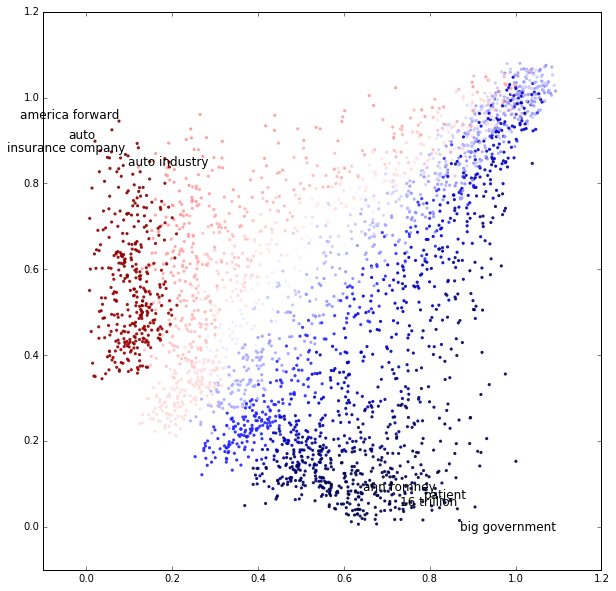

In [239]:
import imp
imp.reload(texttoideas.RudderChart)

rudder_chart = texttoideas.RudderChart.RudderChart(term_doc_mat, jitter=0.1)
plt.rcParams['figure.figsize'] = (10, 10)
drawn_df, fig_html = rudder_chart.draw('democrat')
open('fig.html','w').write(fig_html)

In [229]:
term_doc_mat._category_idx_store = texttoideas.IndexStore()
term_doc_mat._category_idx_store.getidx('democrat')
term_doc_mat._category_idx_store.getidx('republican')


1